In [69]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [38]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

In [39]:
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
#x = layers.Dense(2, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [40]:
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

In [41]:
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [42]:
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [43]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

In [44]:
vae.summary()
decoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
____________________________________________________________________________________________

In [45]:
#load the data and split into train + test sets
(x_train, _), (x_test, y_test) = mnist.load_data()

In [46]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [47]:
vae.fit(x=x_train,y=x_train, shuffle=True, epochs=10, batch_size=batch_size)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.2322
Epoch 2/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.1994
Epoch 3/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.1902
Epoch 4/10
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1868
Epoch 5/10
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.1846
Epoch 6/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.1827
Epoch 7/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.1823
Epoch 8/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.1809
Epoch 9/10
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.1811
Epoch 10/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.1799


In [57]:
# x_test is data
# encoded: means we are mapping our data point (x_test) into latent space; give us a point in latent space
encoded = encoder.predict(x_test)

[ 1.110978   -0.21763772]


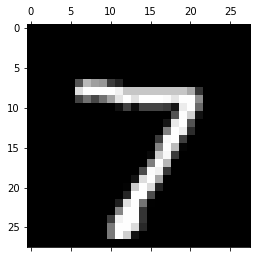

In [58]:
print(encoded[0])
plt.matshow(x_test[0][:,:,0], cmap='gray')

[-0.89966667 -4.0763674 ]


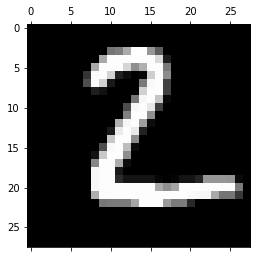

In [59]:
print(encoded[1])
plt.matshow(x_test[1][:,:,0], cmap='gray')

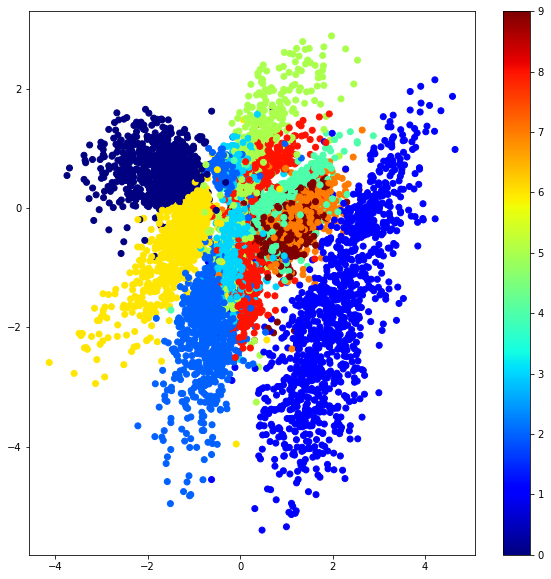

In [61]:
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

HOMEWORK 1

Interpolate between two latent vectors (i.e., moving in the latent space) and decode and visualize the interpolations. Provide a code (python notebook) to do this interpolation; and provide 3 interpolated images in-between.

In [62]:
def interpolate(v1, v2):
    outputs = []
    x1 = v1[0]
    y1 = v1[1]
    x2 = v2[0]
    y2 = v2[1]
    xs = np.linspace(x1, x2, 5)
    ys = np.linspace(y1, y2, 5)
    
    for i in range(len(xs)):    
        decoded_ = decoder.predict([[[xs[i], ys[i]]]])      
        outputs.append(decoded_)
        plt.matshow(decoded_[0][:,:,0], cmap='gray')
        
    return xs, ys

In [63]:
print(encoded[0])
print(encoded[1])

[ 1.110978   -0.21763772]
[-0.89966667 -4.0763674 ]


(array([ 1.110978  ,  0.60831683,  0.10565567, -0.3970055 , -0.89966667]),
 array([-0.21763772, -1.18232014, -2.14700256, -3.11168498, -4.0763674 ]))

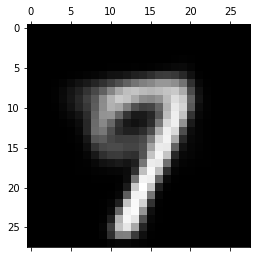

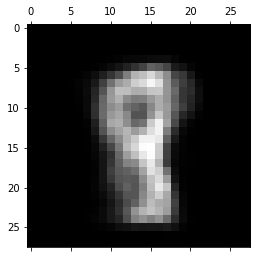

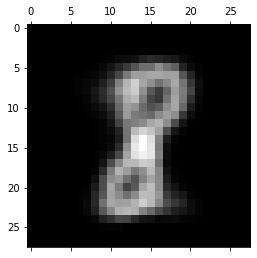

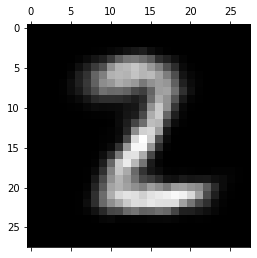

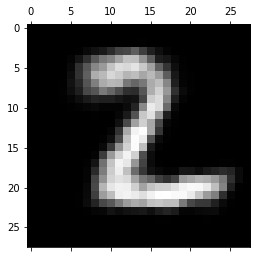

In [67]:
interpolate([ 1.110978, -0.21763772], [-0.89966667, -4.0763674])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
file = 'Rep1_MOB_count_matrix-1.tsv'
data_orig = pd.read_csv(file, sep='\t') 
names = list(data_orig.columns[1:]) #extract gene names
data_orig

,Unnamed: 0,Nop58,Arl6ip4,Lix1,Chrm1,Nap1l1,Kat6a,Fam134c,Lrpprc,Srgap3,...,Gm5431,A630033H20Rik,Srd5a2,Olfr128,Sult5a1,Slc14a2,Lgals12,Gm14124,Olfr699,Zp3r
0,17.002x8.987,1,5,4,2,2,1,8,1,3,...,0,0,0,0,0,0,0,0,0,0
1,17.889x8.992,0,1,2,2,4,8,0,0,10,...,0,0,0,0,0,0,0,0,0,0
2,19.855x8.988,1,0,0,1,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,18.9x8.977,0,0,2,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,20.909x10.916,0,0,1,0,4,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,24.027x12.93,0,0,7,0,6,2,1,0,9,...,0,0,0,0,0,0,0,0,0,0
263,24.002x13.934,0,0,0,0,6,11,0,8,12,...,0,0,0,0,0,0,0,0,0,0
264,26.06x19.962,1,0,2,0,1,0,2,0,7,...,0,0,0,0,0,0,0,0,0,0
265,26.098x18.948,0,0,0,0,3,0,0,0,1,...,1,4,0,0,0,0,0,0,0,0


In [11]:
coord1 = data_orig.iloc[0,0]
x = [float(i.partition('x')[0]) for i in data_orig.iloc[:,0]]
y = [float(i.partition('x')[2]) for i in data_orig.iloc[:,0]]
# since coordinates are non-integer we need to round them
x_round = [int(i+0.5) for i in x] 
y_round = [int(i+0.5) for i in y]

In [12]:
data = []
    
#loop over genes
for i in range(1,data_orig.shape[1]):
    mat = np.zeros([32,32])
    #fill spatial arrays for each gene
    for x_, y_, val in zip(x_round, y_round, data_orig.iloc[:,i]):
        mat[y_,x_] = val
    #scaling the data on each gene from 0 to 1
    mat = mat/(mat.max())
    data.append(mat)
data = np.array(data)

In [13]:
gene_id = names.index('Penk')
print(gene_id)

1553


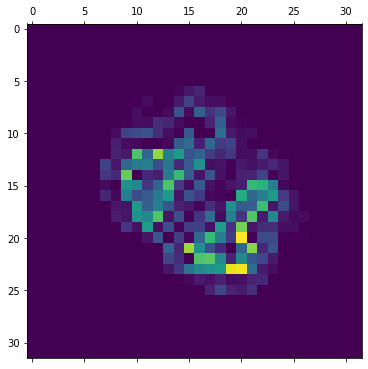

In [16]:
plt.rcParams["figure.figsize"] = (6,6)
gene_id = names.index('Gad1')
plt.matshow(data[gene_id])

In [17]:
area_a = [(15,9),(15,10),(15,11),
          (16,9),(16,10),(16,11),
          (17,9),(17,10),(17,11)]

area_b = [(21,17),(21,18),(21,19),
          (22,17),(22,18),(22,19),
          (23,17),(23,18),(23,19)]

area_c = [(17,15),(15,17),(14,19),
          (16,18),(16,16),(19,14),
          (21,12),(18,16),(17,17)]

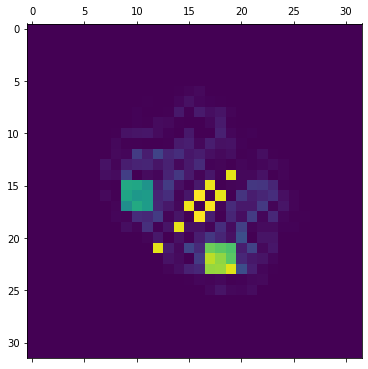

In [18]:
mat_a = np.zeros( (32,32) )
for c in area_a:
    x=c[1]
    y=c[0]
    mat_a[y,x] = 2
    
mat_b = np.zeros( (32,32) )
for c in area_b:
    x=c[1]
    y=c[0]
    mat_b[y,x] = 3
    
mat_c = np.zeros( (32,32) )
for c in area_c:
    x=c[1]
    y=c[0]
    mat_b[y,x] = 4
    
plt.matshow(mat_b+mat_a+mat_c+data[gene_id])

In [19]:
count_a = np.zeros( len(data) )
for c in area_a:
    x=c[1]
    y=c[0]
    count_a = count_a + data[:,y,x]
count_a = count_a / 9

count_b = np.zeros( len(data) )
for c in area_b:
    x=c[1]
    y=c[0]
    count_b = count_b + data[:,y,x]
count_b = count_b / 9

count_c = np.zeros( len(data) )
for c in area_c:
    x=c[1]
    y=c[0]
    count_c = count_c + data[:,y,x]
count_c = count_c / 9

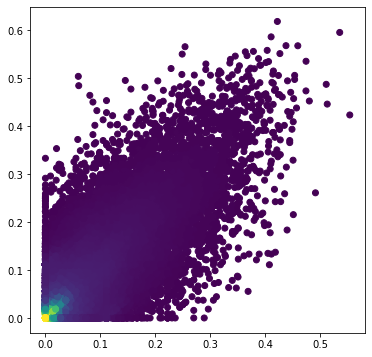

In [20]:
# Calculate the point density
# gaussian_kde(kernel density estimation) is a way to estimate the probability density function 
# (PDF) of a random variable

from scipy.stats import gaussian_kde
xy = np.vstack([count_a,count_b])
z = gaussian_kde(xy)(xy)

plt.scatter(count_a, count_b, c=z)

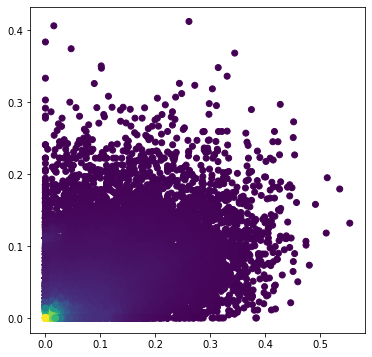

In [21]:
xy = np.vstack([count_a,count_c])
z = gaussian_kde(xy)(xy)

plt.scatter(count_a, count_c, c=z)

In [22]:
from scipy.stats import pearsonr

print('pearson a,b: ', pearsonr(count_a, count_b))
print('pearson a,c: ', pearsonr(count_a, count_c))

pearson a,b:  (0.7668108660328982, 0.0)
pearson a,c:  (0.4572741611362924, 0.0)


Dimensional reduction

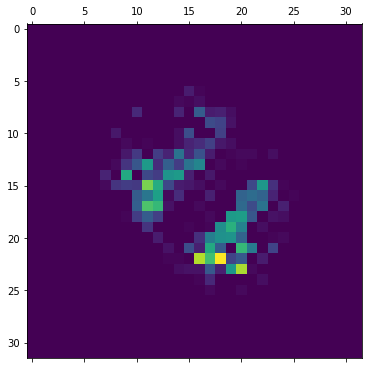

In [23]:
gene_id = names.index('Penk')
plt.matshow(data[gene_id])

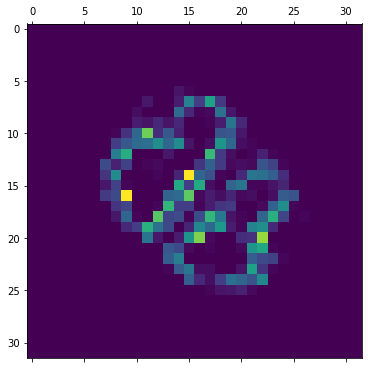

In [24]:
gene_id = names.index('Doc2g')
plt.matshow(data[gene_id])

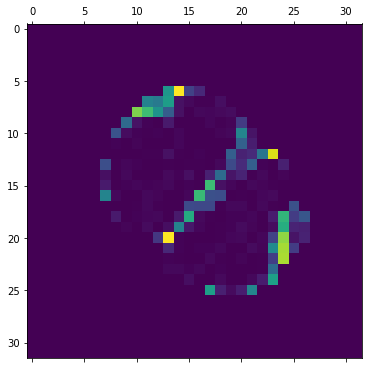

In [25]:
gene_id = names.index('Kctd12')
plt.matshow(data[gene_id])

In [26]:
Penk_avg = np.average(data_orig['Penk'])
Doc2g_avg = np.average(data_orig['Doc2g'])
Kctd12_avg = np.average(data_orig['Kctd12'])

layer1 = []
for i,j in enumerate(data_orig['Penk']):
    if(j > 1.2*Penk_avg): layer1.append(i)
        
layer2 = []
for i,j in enumerate(data_orig['Doc2g']):
    if(j > 1.2*Doc2g_avg): layer2.append(i)
        
layer3 = []
for i,j in enumerate(data_orig['Kctd12']):
    if(j > 1.2*Kctd12_avg): layer3.append(i)
        
#We stack the lists together, these are the locations we consider for PCA
layer_all = layer1+layer2+layer3

In [28]:
from sklearn.decomposition import PCA
#Create object from class PCA
pca = PCA(n_components=2)
#Only keep data for the chosen position, omit column with coordinates
data_reduced = data_orig.iloc[layer_all,1:]
data_pca = pca.fit_transform(data_reduced)

In [29]:
l1 = [1]*len(layer1)
l2 = [2]*len(layer2)
l3 = [3]*len(layer3)

colormap = l1+l2+l3

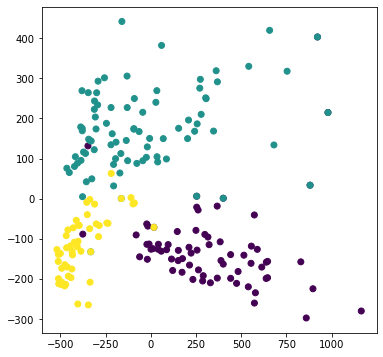

In [30]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=colormap)

In [31]:
import numpy as np
from sklearn.manifold import TSNE
data_embedded = TSNE(n_components=2).fit_transform(data_reduced)

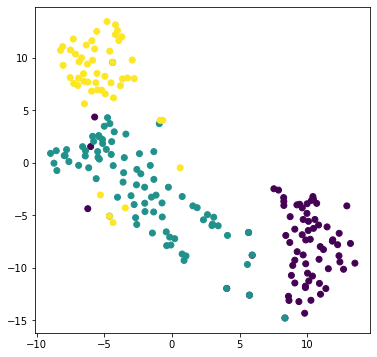

In [32]:
plt.scatter(data_embedded[:,0], data_embedded[:,1], c=colormap)

In [36]:
import umap.umap_ as umap
reducer2d = umap.UMAP(n_components=2)
data_umap2d = reducer2d.fit_transform(data_reduced)

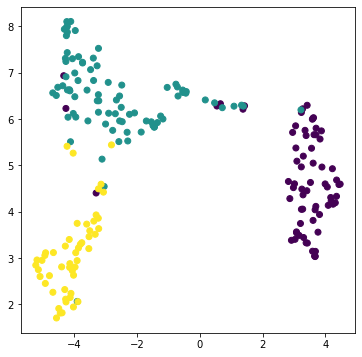

In [37]:
plt.scatter(data_umap2d[:,0], data_umap2d[:,1], c=colormap)

In [38]:
# UMAP can have more than 2 dimensions
reducer = umap.UMAP(n_components=3)
data_umap = reducer.fit_transform(data_orig.iloc[:,1:])
data_umap.shape

(267, 3)

In [39]:
#Postprocess to turn into displayable image

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [40]:
mats1 = []
for i in range(3):
    mat = np.zeros([32,32])
        #fill spatial arrays for each gene
    for x_, y_, val in zip(x_round, y_round, data_umap[:,i]):
        mat[y_,x_] = val
    mat = deprocess_image(mat)
    mats1.append(mat)
mats1 = np.stack(mats1, axis=2)

In [41]:
data_tsne3d = TSNE(n_components=3).fit_transform(data_reduced)

In [42]:
mats2 = []
for i in range(3):
    mat = np.zeros([32,32])
        #fill spatial arrays for each gene
    for x_, y_, val in zip(x_round, y_round, data_tsne3d[:,i]):
        mat[y_,x_] = val
    mat = deprocess_image(mat)
    mats2.append(mat)
mats2 = np.stack(mats2, axis=2)

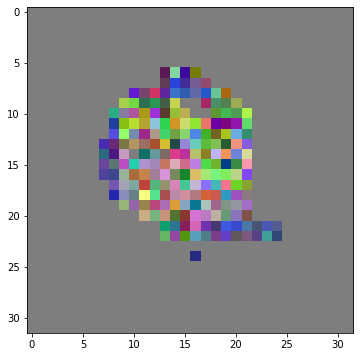

In [43]:
plt.imshow(mats2)

HOMEWORK 2

Apply VAE on the above ST data. Modify the earlier VAE architecture (used on MNIST), such as input data dimensions and other parameters (strides, layers, etc). Keep the 2 dimensions as latent variables.

Visualize the latent variables in a scatter plot.
For 3 randomly chosen genes, visualize the input data and reconstructed data as 2D heatmaps.
Make sure to submit the jupyterlab code.

In [58]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

img_shape = (32, 32, 1)
batch_size = 512
latent_dim = 2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [59]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

vae.summary()
decoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 64)   73792       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 64)   36928       conv2d_5[0][0]                   
____________________________________________________________________________________________

In [49]:
midpoint = int(len(data) * 0.8)
x_train, x_test = data[:midpoint], data[midpoint:]


x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [60]:
vae.fit(x=x_train,y=x_train, shuffle=True, epochs=10, batch_size=batch_size)

Train on 13258 samples
Epoch 1/10
13258/13258 [==============================] - 20s 1ms/sample - loss: 0.4245
Epoch 2/10
13258/13258 [==============================] - 19s 1ms/sample - loss: 0.0278
Epoch 3/10
13258/13258 [==============================] - 20s 2ms/sample - loss: 0.0086
Epoch 4/10
13258/13258 [==============================] - 20s 1ms/sample - loss: 0.0041
Epoch 5/10
13258/13258 [==============================] - 20s 2ms/sample - loss: 0.0026
Epoch 6/10
13258/13258 [==============================] - 20s 2ms/sample - loss: 0.0020
Epoch 7/10
13258/13258 [==============================] - 20s 1ms/sample - loss: 0.0017
Epoch 8/10
13258/13258 [==============================] - 20s 2ms/sample - loss: 0.0015
Epoch 9/10
13258/13258 [==============================] - 20s 2ms/sample - loss: 0.0013
Epoch 10/10
13258/13258 [==============================] - 20s 2ms/sample - loss: 0.0013


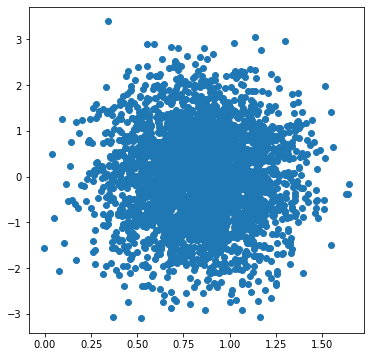

In [62]:
encoded = encoder.predict(x_test)
plt.scatter(encoded[:, 0], encoded[:, 1])
plt.show()

[0.7901201 0.9747302]


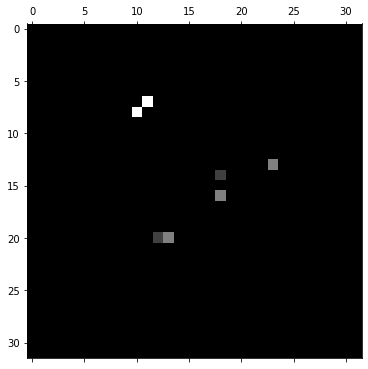

In [67]:
print(encoded[0])
plt.matshow(x_test[0][:,:,0], cmap='gray')

[0.6584779 0.2197748]


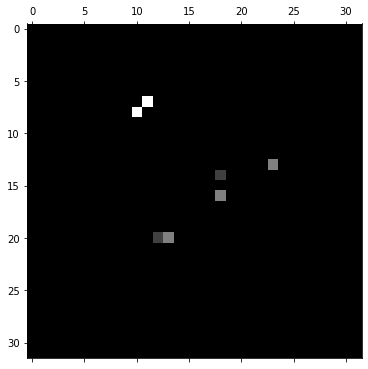

In [68]:
print(encoded[4])
plt.matshow(x_test[0][:,:,0], cmap='gray')

[ 0.71098936 -0.37317297]


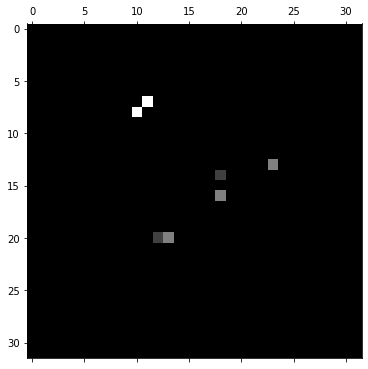

In [69]:
print(encoded[8])
plt.matshow(x_test[0][:,:,0], cmap='gray')